In [1]:
import numpy as np
import pandas as pd
from pandas.testing import assert_index_equal

from tqdm import tqdm

import statsmodels.formula.api as sm
import statsmodels.api as sm_
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from gmm_class import GMM, GMMResults, NFP, results_class_dict
from consumers import us_census, draw_from_census, draw_from_normal, simulate_consumers
from instruments import HausmanIV, BLPIV, DifferentiationIV
from utils import run_2SLS, run_2SGMM, get_logit_elasticities, get_demand_derivatives_logit

In [3]:
df = pd.read_csv("./data/rcl_data_4.csv")
df.set_index(keys=['mktid','firmid', 'prodid'], inplace=True)
df["log_share"] = np.log(df["share"])

## Summary statistics

In [4]:
df

price     share      xvar      wvar  log_share
mktid firmid prodid                                                   
1     1      5       2.606675  0.227237  2.202134 -0.273457  -1.481762
      2      7       3.783296  0.015946  2.755761  0.164740  -4.138520
             8       2.498175  0.175231  1.952670 -0.370695  -1.741651
      3      14      2.396051  0.149334  1.860606 -0.561297  -1.901567
      4      16      2.683033  0.179254  2.317975 -0.640421  -1.718950
...                       ...       ...       ...       ...        ...
20    2      8       3.287951  0.062299  1.968643 -0.588434  -2.775808
      3      9       3.970653  0.030828  2.652435 -0.173701  -3.479338
      4      10      4.638089  0.001708  2.317975 -0.000259  -6.372406
             11      3.895897  0.000724  0.671772  0.914311  -7.230868
             12      4.020247  0.021632  2.660057  0.025131  -3.833588

[188 rows x 5 columns]

In [5]:
df_widxs = df.copy()
df_widxs['firmid'] = df_widxs.index.get_level_values('firmid')
df_widxs['prodid'] = df_widxs.index.get_level_values('prodid')
stats_mktlvl = df_widxs.groupby(by=['mktid']).aggregate({'firmid': 'nunique', 'prodid': 'nunique'})
stats_mktlvl.rename(columns={"firmid": "#Firms", "prodid": "#Products"}, inplace=True)
nfirms = stats_mktlvl["#Firms"]
nprods = stats_mktlvl["#Products"]
df_std = df.groupby('mktid').mean()
df_mean = df.groupby('mktid').median()
stats_mktlvl.join(df_mean.join(df_std,rsuffix='_std',lsuffix='_mean'))

,#Firms,#Products,price_mean,share_mean,xvar_mean,wvar_mean,log_share_mean,price_std,share_std,xvar_std,wvar_std,log_share_std
mktid,,,,,,,,,,,,
1,4,7,2.606675,0.149334,1.952670,-0.370695,-1.901567,2.750983,0.118469,1.945542,-0.293838,-2.483372
2,4,7,2.430668,0.070118,2.685479,-0.564728,-2.657577,2.608820,0.136178,2.631723,-0.270162,-3.416234
3,4,7,2.844954,0.082008,2.660057,-0.126529,-2.500937,3.098984,0.128079,2.576645,0.065384,-3.597887
4,4,11,3.326305,0.009768,1.946938,0.218622,-4.628668,3.530610,0.072886,1.983285,0.168326,-4.950860
5,4,11,2.663987,0.027104,1.946938,-0.089058,-3.608089,2.854352,0.082693,1.801961,-0.154398,-3.747254
6,4,8,2.698184,0.039247,1.949804,0.131254,-3.252579,2.950200,0.106947,1.940615,0.029890,-3.461575
7,3,6,2.966885,0.122192,2.030004,0.142384,-2.121575,2.868110,0.121251,1.825464,-0.006352,-2.290008
8,4,12,3.088131,0.014099,2.077402,0.061042,-4.261649,3.062927,0.073310,2.144377,0.101264,-3.847605
9,4,10,3.246889,0.021610,1.957790,0.171797,-3.875696,3.361858,0.076573,2.155827,0.141241,-3.888033


In [6]:
df_std = df.groupby('mktid').std()
df_mean = df.groupby('mktid').mean()
df_min = df.groupby('mktid').min()
df_max = df.groupby('mktid').max()
stats_mktlvl.join(df_mean.join(df_std.join(df_min.join(df_max, rsuffix='_max'), rsuffix='_min'),rsuffix='_std',lsuffix='_mean'))

,#Firms,#Products,price_mean,share_mean,xvar_mean,wvar_mean,log_share_mean,price_std,share_std,xvar_std,...,price_min,share_min,xvar_min,wvar_min,log_share_min,price_max,share_max,xvar_max,wvar_max,log_share_max
mktid,,,,,,,,,,,,,,,,,,,,,
1,4,7,2.750983,0.118469,1.945542,-0.293838,-2.483372,0.504559,0.083901,0.645296,...,2.310209,0.015946,0.671772,-0.640421,-4.138520,3.783296,0.227237,2.755761,0.164740,-1.481762
2,4,7,2.608820,0.136178,2.631723,-0.270162,-3.416234,0.705770,0.156169,0.432091,...,1.733794,0.000308,1.857874,-1.286910,-8.086862,3.612128,0.409148,3.143323,0.703590,-0.893679
3,4,7,3.098984,0.128079,2.576645,0.065384,-3.597887,0.779273,0.144382,0.471870,...,2.012440,0.001445,1.933339,-0.626037,-6.539659,4.166480,0.369714,3.143323,1.012786,-0.995026
4,4,11,3.530610,0.072886,1.983285,0.168326,-4.950860,0.857782,0.149572,0.740780,...,2.483254,0.000044,0.671772,-0.721385,-10.028818,5.050753,0.498375,3.009212,0.795168,-0.696403
5,4,11,2.854352,0.082693,1.801961,-0.154398,-3.747254,0.846140,0.114486,0.667598,...,1.442446,0.000100,0.671772,-0.612460,-9.205419,4.568714,0.367852,2.755761,0.250892,-1.000074
6,4,8,2.950200,0.106947,1.940615,0.029890,-3.461575,0.778380,0.133469,0.577514,...,2.179758,0.000150,0.671772,-0.949792,-8.806705,4.542324,0.367265,2.660057,0.872742,-1.001671
7,3,6,2.868110,0.121251,1.825464,-0.006352,-2.290008,0.376994,0.066176,0.913509,...,2.191228,0.028310,0.671772,-0.935112,-3.564546,3.203889,0.191099,2.755761,0.796828,-1.654964
8,4,12,3.062927,0.073310,2.144377,0.101264,-3.847605,0.587061,0.138590,0.603179,...,1.890271,0.000790,0.779767,-0.139097,-7.143806,3.928379,0.491212,3.009212,0.699992,-0.710880
9,4,10,3.361858,0.076573,2.155827,0.141241,-3.888033,0.478922,0.119418,0.558861,...,2.739443,0.000681,1.305570,-0.459850,-7.291230,4.237235,0.349676,3.143323,0.559578,-1.050748


## Logit model warmup

### 1. with OLS

To Do: add a constant in the dataset, as 2SLS does not add one by default

In [7]:
logit_ols = sm.ols(formula="log_share ~ xvar + price", data=df).fit()
print(logit_ols.summary())

                            OLS Regression Results                            
Dep. Variable:              log_share   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     340.1
Date:                Thu, 02 Feb 2023   Prob (F-statistic):           1.07e-62
Time:                        15:56:31   Log-Likelihood:                -274.26
No. Observations:                 188   AIC:                             554.5
Df Residuals:                     185   BIC:                             564.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4678      0.360      4.073      0.0

eval_env: 1


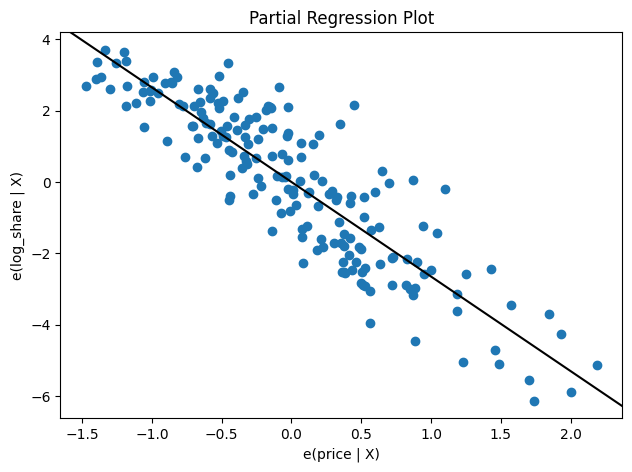

In [8]:
# Partial Regression Plot of logshare-E[logshare|xvar] on price-E[price|xvar]
fig = sm_.graphics.plot_partregress("log_share", "price", ["xvar"], data=df, obs_labels = False)
fig.tight_layout(pad=1.0)

### 2. With 2SLS

In [9]:
logit_2sls = run_2SLS(df, ["wvar"])

                          IV2SLS Regression Results                           
Dep. Variable:              log_share   R-squared:                       0.785
Model:                         IV2SLS   Adj. R-squared:                  0.783
Method:                     Two Stage   F-statistic:                     86.48
                        Least Squares   Prob (F-statistic):           3.04e-27
Date:                Thu, 02 Feb 2023                                         
Time:                        15:56:34                                         
No. Observations:                 188                                         
Df Residuals:                     185                                         
Df Model:                           2                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6599      0.583      2.846      0.0

### GMM

In [10]:
logit_2sgmm = run_2SGMM(df, ["wvar"])

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
                                IVGMM Results                                 
Dep. Variable:              log_share   Hansen J:                    1.403e-11
Model:                          IVGMM   Prob (Hansen J):                   nan
Method:                           GMM                                         
Date: 

In [11]:
def get_logit_elasticities(mktid: int) -> pd.DataFrame:
    constant, alpha, beta = logit_2sgmm.params
    df_mkt = df[df.index.get_level_values('mktid')==mktid].droplevel('mktid')
    N = df_mkt["price"].shape[0]
    print(N)
    mkt_elst = -alpha*np.dot(np.ones((N,1)), (df_mkt["price"]*df_mkt["share"]).to_numpy().reshape((1,N))) + alpha*np.diag(df_mkt["price"])
    return pd.DataFrame(mkt_elst, index=df_mkt.index, columns=df_mkt.index)

def get_demand_derivatives_logit(mktid: int) -> pd.DataFrame:
    constant, alpha, beta = logit_2sgmm.params
    df_mkt = df[df.index.get_level_values('mktid')==mktid].droplevel('mktid')
    N = df_mkt["share"].shape[0]
    #dqdp = np.dot(df_mkt["share"],(1-df_mkt["share"])) - alpha*np.ones((N,1)) + alpha*np.diag(df_mkt["share"]*df_mkt["share"])
    mkt_elst = -alpha*np.dot(np.ones((N,1)), (df_mkt["share"]*(1-df_mkt["share"])).to_numpy().reshape((1,N))) + alpha*np.diag(df_mkt["share"])
    return pd.DataFrame(mkt_elst, index=df_mkt.index, columns=df_mkt.index)

Matrix of own and cross-price elasticities for market 1:

In [12]:
get_logit_elasticities(1)

7


firmid                1          2                   3         4            \
prodid               5          7         8         14        16        17   
firmid prodid                                                                
1      5      -5.501997   0.164786  1.195695  0.977334  1.313660  0.288092   
2      7       1.617905 -10.168952  1.195695  0.977334  1.313660  0.288092   
       8       1.617905   0.164786 -5.627849  0.977334  1.313660  0.288092   
3      14      1.617905   0.164786  1.195695 -5.567268  1.313660  0.288092   
4      16      1.617905   0.164786  1.195695  0.977334 -6.014809  0.288092   
       17      1.617905   0.164786  1.195695  0.977334  1.313660 -7.849992   
       18      1.617905   0.164786  1.195695  0.977334  1.313660  0.288092   

firmid                  
prodid              18  
firmid prodid           
1      5       0.29583  
2      7       0.29583  
       8       0.29583  
3      14      0.29583  
4      16      0.29583  
       17      0.29583  
       18     -6.01430

In [13]:
get_demand_derivatives_logit(1)

firmid                1         2                   3         4            \
prodid               5         7         8         14        16        17   
firmid prodid                                                               
1      5      -0.141041  0.042862  0.394757  0.346981  0.401851  0.093270   
2      7       0.479637 -0.000695  0.394757  0.346981  0.401851  0.093270   
       8       0.479637  0.042862 -0.083870  0.346981  0.401851  0.093270   
3      14      0.479637  0.042862  0.394757 -0.060913  0.401851  0.093270   
4      16      0.479637  0.042862  0.394757  0.346981 -0.087766  0.093270   
       17      0.479637  0.042862  0.394757  0.346981  0.401851 -0.003423   
       18      0.479637  0.042862  0.394757  0.346981  0.401851  0.093270   

firmid                   
prodid               18  
firmid prodid            
1      5       0.122050  
2      7       0.122050  
       8       0.122050  
3      14      0.122050  
4      16      0.122050  
       17      0.122050  
       18     -0.006003

## Computing Instrumental Variables

In [14]:
df = HausmanIV(df)
df = BLPIV(df)
df = DifferentiationIV(df)

14.562190736471745 3.2527472527472527 13.873626373626374 15.81868131868132


In [15]:
logit_2sls_hausman = run_2SLS(df, ["hausman_iv"])

                          IV2SLS Regression Results                           
Dep. Variable:              log_share   R-squared:                       0.784
Model:                         IV2SLS   Adj. R-squared:                  0.781
Method:                     Two Stage   F-statistic:                     97.55
                        Least Squares   Prob (F-statistic):           2.23e-29
Date:                Thu, 02 Feb 2023                                         
Time:                        15:57:29                                         
No. Observations:                 182                                         
Df Residuals:                     179                                         
Df Model:                           2                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3328      0.592      3.941      0.0

Checking df has correctly been added hte instruments:

In [16]:
df

price     share      xvar      wvar  log_share  \
mktid prodid firmid                                                      
1     5      1       2.606675  0.227237  2.202134 -0.273457  -1.481762   
      7      2       3.783296  0.015946  2.755761  0.164740  -4.138520   
      8      2       2.498175  0.175231  1.952670 -0.370695  -1.741651   
      14     3       2.396051  0.149334  1.860606 -0.561297  -1.901567   
      16     4       2.683033  0.179254  2.317975 -0.640421  -1.718950   
...                       ...       ...       ...       ...        ...   
20    2      1       2.708315  0.515946  2.181564 -0.065767  -0.661754   
      3      1       5.394167  0.000116  2.316431  0.043551  -9.066113   
      6      2       3.677919  0.012641  1.952670 -0.428108  -4.370777   
      7      2       5.377402  0.000364  3.009212  0.165925  -7.918836   
      8      2       3.287951  0.062299  1.968643 -0.588434  -2.775808   

                     hausman_iv  blp1  blp2      blp3       blp4    diff_iv  \
mktid prodid firmid                                                           
1     5      1         2.997245     6     7  0.000000  11.416658   5.610647   
      7      2         3.950095     5     7  1.952670   8.910361  20.700417   
      8      2         2.964054     5     7  2.755761   8.910361   3.129697   
      14     3         3.679174     6     7  0.000000  11.758187   2.697010   
      16     4         3.114423     4     7  2.529646   8.771171   7.487307   
...                         ...   ...   ...       ...        ...        ...   
20    2      1         2.738265     3     6  4.034082   6.930525   0.000000   
      3      1         2.483354     3     6  3.899215   6.930525   0.000000   
      6      2         3.963566     3     6  4.977855   6.215646   0.000000   
      7      2         3.805177     3     6  3.921313   6.215646   0.000000   
      8      2         2.892256     3     6  4.961882   6.215646   0.000000   

                     diff_iv_prodband0  diff_iv_prodband1  diff_iv_prodband2  
mktid prodid firmid                                                           
1     5      1                       0                 17                 18  
      7      2                       0                 15                 18  
      8      2                       0                 16                 18  
      14     3                       0                 15                 18  
      16     4                       0                 15                 18  
...                                ...                ...                ...  
20    2      1                       0                  0                  0  
      3      1                       0                  0                  0  
      6      2                       0                  0                  0  
      7      2                       0                  0                  0  
      8      2                       0                  0                  0  

[182 rows x 14 columns]

## Random Coefficients Logit Model

In [17]:
cons = simulate_consumers(n=100)

In [18]:
nfp = NFP(df, cons, instruments=["hausman_iv", "diff_iv", "diff_iv_prodband0", "diff_iv_prodband1", "diff_iv_prodband2", "wvar"], tol_fp=1e-4)
theta2_0=np.random.rand(1,2)

In [8]:
# Check for full-rank instrument matrix
instr_noconst = list(set(nfp.Z.columns).difference(["const"]))
instr_corr = nfp.Z[instr_noconst].corr()
instr_rk = np.linalg.matrix_rank(instr_corr)
print("Instrument matrix of rank {0:d}/{1:d}".format(instr_rk, len(instr_noconst)))

# Instrument matrix condtion number
print("Condition number of correlation matrix: {0:.2f}".format(np.linalg.cond(instr_corr)))

Instrument matrix of rank 7/7
Condition number of correlation matrix: 87.72


In [19]:
nfp.verbose = False
nfp_res = nfp.fit(theta2_0, optim_method="nm", maxiter=0)

Optimization terminated successfully.
         Current function value: 1.086295
         Iterations: 38
         Function evaluations: 79


In [9]:
nfp_res

{'theta1_est': const    5.404689
 price   -3.212786
 xvar     1.741575
 dtype: float64,
 'theta2_est': array([1.67422346, 0.59501588]),
 'dmdshift_est': mktid  prodid  firmid
 1      5       1         0.193941
        7       2         0.151405
        8       2         0.072539
        14      3        -0.242022
        16      4        -0.032398
                            ...   
 20     2       1        -0.246120
        3       1        -0.304896
        6       2        -0.374441
        7       2        -0.767542
        8       2        -0.064194
 Length: 182, dtype: float64,
 'mu_est':                         cust0     cust1     cust2     cust3     cust4  \
 mktid prodid firmid                                                     
 1     5      1      -2.575177 -2.475245 -3.420934 -0.778028  0.915524   
       7      2      -3.361118 -2.292470 -3.168436 -0.985687  1.252488   
       8      2      -2.221033 -2.557603 -3.534710 -0.684457  0.763689   
       14     3      -2.090336

In [21]:
def robustness_analysis1(pi1_min:float, pi1_max:float, pi2: float, n:int):
    theta1_ests = {}
    theta2_ests = {}
    dmd_shifts = {}

    nfp = NFP(df, cons, instruments=["hausman_iv", "diff_iv", "diff_iv_prodband0", "diff_iv_prodband1", "diff_iv_prodband2", "wvar"], tol_fp=1e-4)
    for pi1 in range(pi1_min, pi1_max, (pi1_max-pi1_min)/n):
        theta2_init = np.array([pi1, pi2])
        nfp_res = nfp.fit(theta2_init, optim_method="nm", maxiter=0)
        theta1_ests[theta2_init] = nfp_res['theta1_est']
        theta2_ests[theta2_init] = nfp_res['theta2_est']
        dmd_shifts[theta2_init] = nfp_res['dmdshift_est']
    return theta1_ests, theta2_ests, dmd_shifts

In [ ]:
def robustness_analysis2(pi2_min:float, pi2_max:float, pi1: float, n:int):
    theta1_ests = {}
    theta2_ests = {}
    dmd_shifts = {}

    nfp = NFP(df, cons, instruments=["hausman_iv", "diff_iv", "diff_iv_prodband0", "diff_iv_prodband1", "diff_iv_prodband2", "wvar"], tol_fp=1e-4)
    for pi2 in range(pi2_min, pi2_max, (pi2_max-pi2_min)/n):
        theta2_init = np.array([pi1, pi2])
        nfp_res = nfp.fit(theta2_init, optim_method="nm", maxiter=0)
        theta1_ests[theta2_init] = nfp_res['theta1_est']
        theta2_ests[theta2_init] = nfp_res['theta2_est']
        dmd_shifts[theta2_init] = nfp_res['dmdshift_est']
    return theta1_ests, theta2_ests, dmd_shifts

In [ ]:
pi2 = 0.
pi1_min = -3.
pi1_max = 3.
theta1_ests, theta2_ests, dmd_shifts = robustness_analysis1()